In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
import warnings

warnings.filterwarnings('ignore')

### Создание классов для модели "Случайный лес"

В результате экспетиментов в качестве модели выбран "Случайнй лес".

Так как среди признаков много категориальных, то подстроение случайного леса, основанное на выборке параметров методом бутстрап, работает плохо, так как некоторые деревья при этом строятся только на категориальных переменных. Поэтому в алгоритм внесены изменения, так чтобы дерево всегда строилось на всем множетстве переменных - тесты показали, что в этом случае результат получается лучше.

В качестве гиперпараметров оставлены только глубина дерева и количество деревьев, как наиболее существенно влияющие на результат.

In [3]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        p_cnt = 0
        for label in self.labels:
            if label == 1:
                p_cnt += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = p_cnt/len(self.labels)
        return prediction     

class OurDecisionTreeRegressor:
    def __init__(
        self, 
        max_depth: int = 0):
        
        self.max_depth = max_depth
        self.cur_leaf = 0
        self.depth = 0
        self.cur_leaf = 0
        self.tree = None
        
    def fit(self, data, labels):
        
        self.tree = self.build_tree(data, labels, 0)
        return self
    
    
    def predict(self, data):
    
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.tree)
            classes.append(prediction)
        return classes
    
    
    def build_tree(self, data, labels, cur_depth):


        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)

        #  Ограничение на глубину дерева
        if cur_depth >= self.max_depth:
            return Leaf(data, labels)


        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
        
        self.depth += 1
        
        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, cur_depth + 1)
        false_branch = self.build_tree(false_data, false_labels, cur_depth + 1)
        

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels):
    
        #  обозначим минимальное количество объектов в узле
        min_leaf = 5

        current_criter = self.criterion(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features): 
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_criter)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    # Разбиение датасета в узле
    @staticmethod
    def split(data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)
        
        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    # Расчет качества
    def quality(self, left_labels, right_labels, current_criter):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_criter - p * self.criterion(left_labels) - \
                (1 - p) * self.criterion(right_labels)
    
    # Расчет критерия Джини или Энтропии
    @staticmethod
    def criterion(labels):
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2
        return impurity
    
    # классификация объектов
    def classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)

In [4]:
class OurRandomForestRegressor:
    def __init__(
        self, 
        n_trees: int = 0,
        max_depth: int = 0):
        
        self.n_trees = n_trees
        self.max_depth = max_depth
        
    def fit(self, data, labels):
        
        self.forest = []
        self.forest = self.random_forest(data, labels)
        return self
    
    def predict(self, data):
        return self.tree_vote(data)
    
    
    def random_forest(self, data, labels):

        bootstrap = self.get_bootstrap(data, labels)

        for b_data, b_labels in bootstrap:
            tree = OurDecisionTreeRegressor(max_depth=self.max_depth)
            self.forest.append(tree.fit(b_data, b_labels))

        return self.forest
    
    
    # предсказание голосованием деревьев
    def tree_vote(self, data):

        # добавим предсказания всех деревьев в список
        predictions = []
        for tree in self.forest:
            # predictions.append(self.predict_on_tree(data, tree))
            predictions.append(tree.predict(data))

        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            #voted_predictions.append(max(set(obj), key=obj.count))
            voted_predictions.append(np.mean(obj))

        return voted_predictions
    
    def get_bootstrap(self, data, labels):
        n_samples = data.shape[0]
        bootstrap = []

        for i in range(self.n_trees):
            b_data = np.zeros(data.shape)
            b_labels = np.zeros(labels.shape)

            for j in range(n_samples):
                sample_index = random.randint(0, n_samples-1)
                b_data[j] = data[sample_index]
                b_labels[j] = labels[sample_index]
            bootstrap.append((b_data, b_labels))

        return bootstrap
    
    @staticmethod
    def get_subsample(len_sample):
        # будем сохранять не сами признаки, а их индексы
        sample_indexes = [i for i in range(len_sample)]

        len_subsample = int(np.sqrt(len_sample))
        subsample = []

        random.shuffle(sample_indexes)
        for _ in range(len_subsample):
            subsample.append(sample_indexes.pop())

        return subsample

In [5]:
def my_roc_auc_score(y_true, y_score):
       
    y_score = np.array(y_score)
    y_true = np.array(y_true)
    y_true = (y_true == 1)

    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]
  
    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    tps = np.cumsum(y_true)[threshold_idxs]
    fps = 1 + threshold_idxs - tps

    tps = np.r_[0, tps]
    fps = np.r_[0, fps]
    
    fpr = fps / fps[-1]
    tpr = tps / tps[-1]

    return np.trapz(tpr, fpr)

### Подготовка данных

In [43]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
df = pd.concat([train_data, test_data], axis=0)

In [44]:
df.head()

,Id,age,biology,chemistry,choose,english,geography,history,lesson_price,mean_exam_points,physics,qualification,years_of_experience
0,0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,2150.0,74.0,0.0,2.0,0.0
1,1,52.0,1.0,0.0,1.0,0.0,0.0,1.0,1250.0,57.0,1.0,2.0,2.0
2,2,29.0,0.0,0.0,0.0,0.0,0.0,0.0,1750.0,66.0,1.0,1.0,3.0
3,3,33.0,0.0,0.0,1.0,0.0,0.0,0.0,1050.0,66.0,0.0,1.0,3.0
4,4,46.0,0.0,0.0,0.0,0.0,0.0,0.0,2250.0,73.0,1.0,2.0,3.0


Посчитаем базовые статистики по набору данных

In [45]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,20000.0,9999.50000,5773.647028,0.0,4999.75,9999.5,14999.25,19999.0
age,20000.0,45.86270,8.031163,23.0,40.00,46.0,51.00,68.0
biology,20000.0,0.11650,0.320832,0.0,0.00,0.0,0.00,1.0
chemistry,20000.0,0.12480,0.330500,0.0,0.00,0.0,0.00,1.0
choose,10000.0,0.11090,0.314024,0.0,0.00,0.0,0.00,1.0
english,20000.0,0.05405,0.226122,0.0,0.00,0.0,0.00,1.0
geography,20000.0,0.02845,0.166259,0.0,0.00,0.0,0.00,1.0
history,20000.0,0.01655,0.127581,0.0,0.00,0.0,0.00,1.0
lesson_price,20000.0,1701.17500,525.014430,200.0,1300.00,1550.0,2150.00,3950.0
mean_exam_points,20000.0,64.29230,13.582978,32.0,55.00,63.0,73.00,100.0


Видим, что пропуски отсутствуют, категориальные признаки представлены числовыми значениями, явно выраженные выбросы также отсутствуют.

In [9]:
discrete_feature = [
    feature for feature in df.select_dtypes(include=[np.number])
    if len(df[feature].unique())<25 and feature != 'choose'
]
discrete_feature

['biology',
 'chemistry',
 'english',
 'geography',
 'history',
 'physics',
 'qualification',
 'years_of_experience']

Посмотрим распределение среднего значения целевой переменной в группировке по дискретным признакам

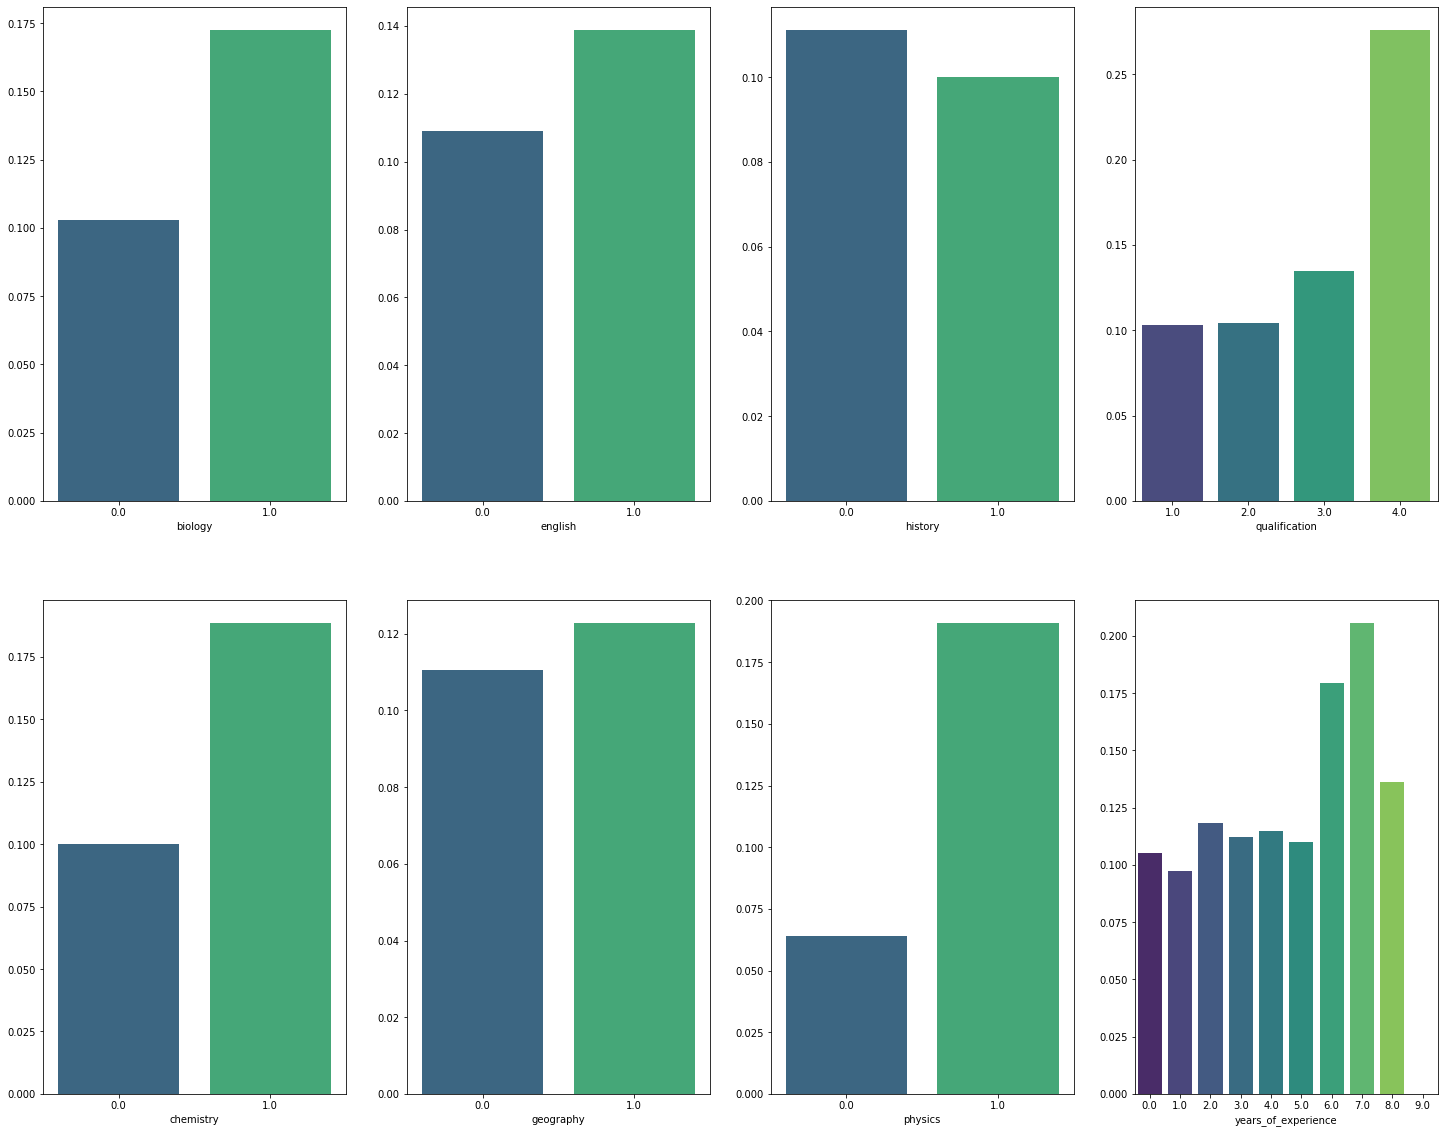

In [10]:
ig, axes = plt.subplots(2, 4, figsize=(25, 20))

for num, feature in enumerate(discrete_feature):
    data = train_data.copy()
    statistics = data.groupby([feature])["choose"].mean()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        palette="viridis",
        ax=axes[num%2, num//2]
    )

Также посмотрим распределение значений дискретных признаков для значений 0 и 1 целевой переменной

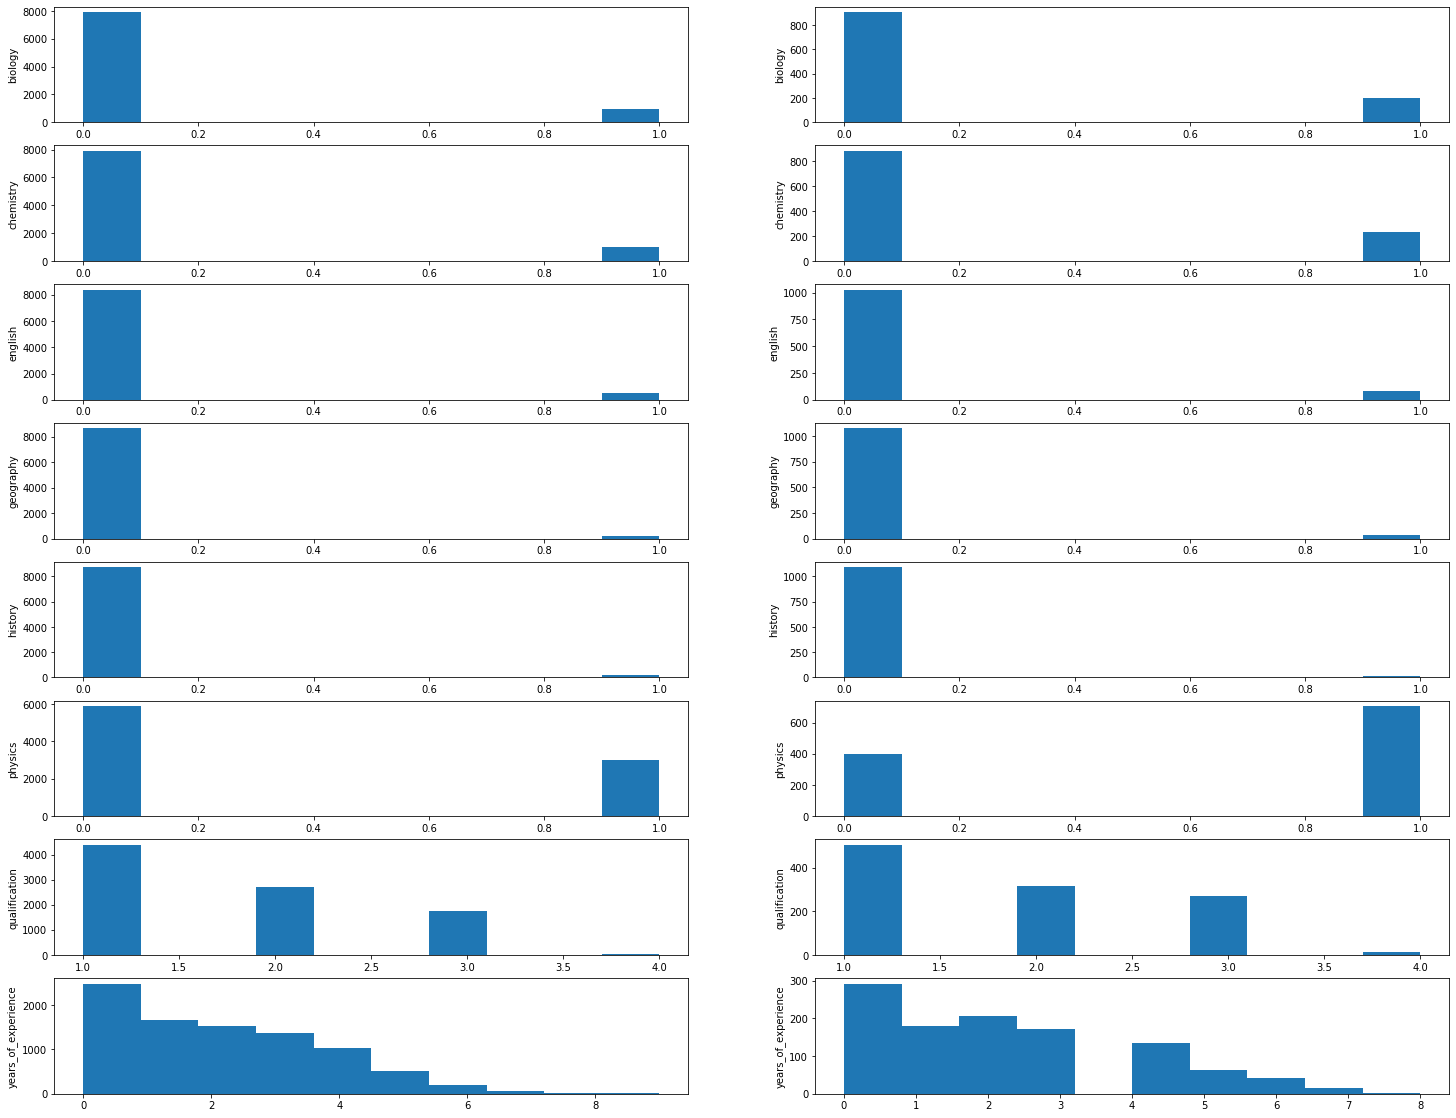

In [11]:
ig, axes = plt.subplots(8, 2, figsize=(25, 20))

for num, feature in enumerate(discrete_feature):
    data = df[df['choose'] == 0].copy()
    axes[num, 0].hist(data[feature])
    axes[num, 0].set_ylabel(feature)

for num, feature in enumerate(discrete_feature):
    data = df[df['choose'] == 1].copy()
    axes[num, 1].hist(data[feature])
    axes[num, 1].set_ylabel(feature)

И распределение значений дискретных признаков на трейне и тесте

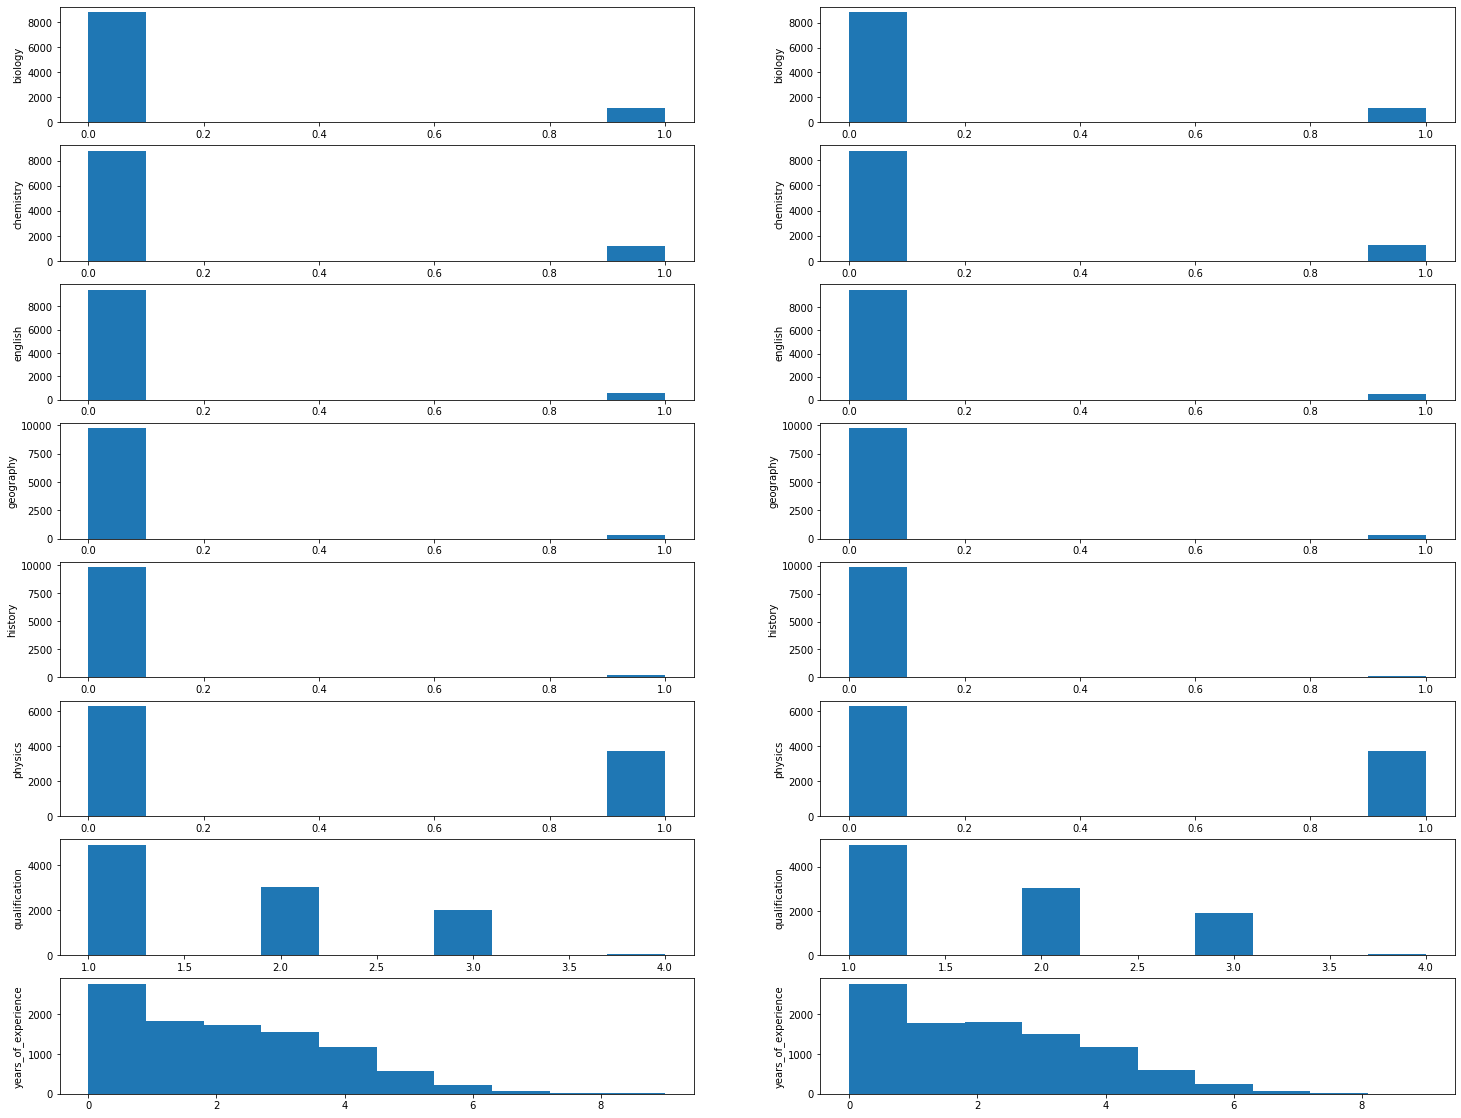

In [12]:
ig, axes = plt.subplots(8, 2, figsize=(25, 20))

for num, feature in enumerate(discrete_feature):
    data = df[np.isnan(df.choose)==False].copy()
    axes[num, 0].hist(data[feature])
    axes[num, 0].set_ylabel(feature)

for num, feature in enumerate(discrete_feature):
    data = df[np.isnan(df.choose)==True].copy()
    axes[num, 1].hist(data[feature])
    axes[num, 1].set_ylabel(feature)

Видим, что из трех показателей, относящихся к предметам, влияние оказывает только физика.

In [13]:
df.groupby(['qualification'], as_index=False).agg({'choose':['mean', 'count']})

qualification    choose      
                     mean count
0           1.0  0.103046  4891
1           2.0  0.104517  3033
2           3.0  0.134787  2018
3           4.0  0.275862    58

Значений для qualification = 4 очень мало, объединим их со значениями 3. Хотя для qualification = 4 доля целевых значений выше, но тесты показали, что с объединенными значениями значение метрики получается выше.

In [46]:
df['qualification2'] = df['qualification'].apply(lambda x: min(x, 3))

Так как их общих соображений очевидно, что на цену урока влияет уровень квалификации преподавателя, очистим показатель lesson_price от этого влияния, разделив на значение медианы цены урока в разрезе каждого уровны квалификации.
Так же из общих соображений можно было бы тем же методом очистить от влияния стажа, но тесты показывают, что в этом случае модель начинает работать хуже. Поэтому оставляет только отношение lesson_price к медиане по qualification, и отдельно переменную years_of_experience.

In [47]:
df2 = df.groupby(['qualification'], as_index=False).agg({'lesson_price':'median'})
df2.rename(columns={'lesson_price': 'qualif_lesson_price_median'} , inplace=True)
df2

,qualification,qualif_lesson_price_median
0,1.0,1350.0
1,2.0,1750.0
2,3.0,2350.0
3,4.0,2400.0


In [48]:
df = df.merge(df2, on='qualification', how='left')
df['qualif_lesson_price'] = df.lesson_price/df.qualif_lesson_price_median

Исслдуем mean_exam_points

In [49]:
df.groupby(['choose'], as_index=False).agg({'mean_exam_points':['median','mean', 'std']})

choose mean_exam_points                      
                   median       mean        std
0    0.0             63.0  63.909909  13.735075
1    1.0             67.0  68.646528  11.589451

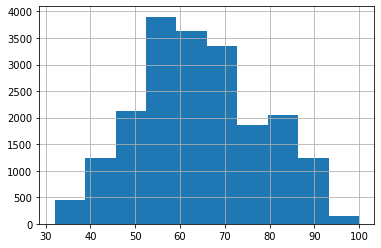

In [50]:
df.mean_exam_points.hist()

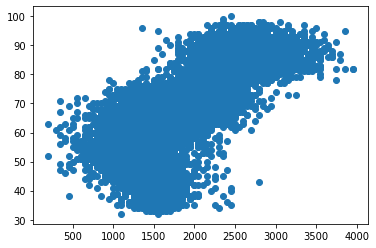

In [51]:
plt.scatter(df.lesson_price, df.mean_exam_points)

In [52]:
df3 = df.groupby(['qualification'], as_index=False).agg({'mean_exam_points':'median'})
df3.rename(columns={'mean_exam_points': 'qualif_mean_exam_points_median'} , inplace=True)
df3

,qualification,qualif_mean_exam_points_median
0,1.0,57.0
1,2.0,66.0
2,3.0,84.0
3,4.0,84.0


In [53]:
df = df.merge(df3, on='qualification', how='left')
df['qualif_mean_exam_points'] = df.mean_exam_points/df.qualif_mean_exam_points_median

In [54]:
df['qualif_mean_exam_points_10'] = df.qualif_mean_exam_points.apply(lambda x: round(x/10, 0))

Распереление mean_exam_points напоминает нормальное и коррелирует с lesson_price. Тесты показали, что модель лучше работает со значениями округленными до 10.

In [23]:
df['mean_exam_points_10'] = df.mean_exam_points.apply(lambda x: round(x/10, 0))

In [24]:
df.groupby(['mean_exam_points_10'], as_index=False).agg({'choose':'mean'})

,mean_exam_points_10,choose
0,3.0,0.000000
1,4.0,0.003759
2,5.0,0.057199
3,6.0,0.126825
4,7.0,0.149075
5,8.0,0.105194
6,9.0,0.166038
7,10.0,0.244898


Существенного влияния показатель "возраст" на модель не обнаружено, поэтому далее он не используется

In [25]:
df.groupby(['choose'], as_index=False).agg({'age':['median','mean', 'std']})

choose    age                     
         median       mean       std
0    0.0   46.0  45.752221  8.025319
1    1.0   46.0  46.191163  8.062900

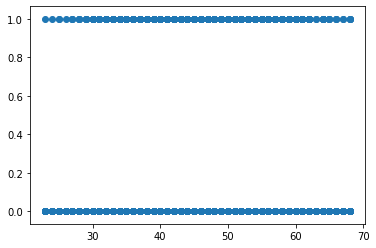

In [26]:
plt.scatter(df.age, df.choose)

Аналогично не оказывают существенное влияние показатели, относящиеся ко всем предметам, кроме физики.

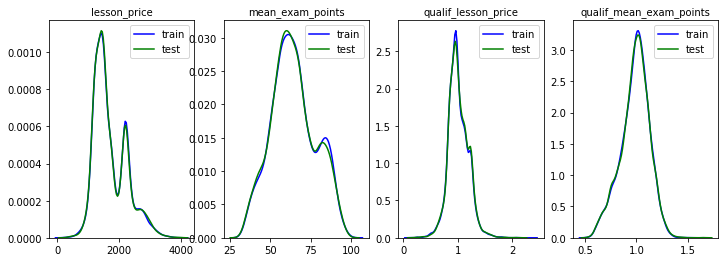

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for num, feature in enumerate(['lesson_price','mean_exam_points','qualif_lesson_price','qualif_mean_exam_points']):
    try:
        train, test = df.loc[np.isnan(df.choose)==False, feature].copy(), df.loc[np.isnan(df.choose)==True, feature].copy()
        sns.kdeplot(train, ax=axes[num%4], color="blue", label="train")
        sns.kdeplot(test, ax=axes[num%4], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train = df.loc[np.isnan(df.choose)==False, feature].copy()
        sns.kdeplot(train, ax=axes[num%4], color="blue", label="train")
    axes[num%4].set_title(feature, fontsize=10)

Видим, что распределение непрерывных показателей практически совпадает для трейна и теста. За счет нормирования на квалицикацию удается сгладить график, убрав "горбик". Однако тесты показали, что если применение qualif_lesson_price вместо lesson_price приводит к улучшению модели, то замена mean_exam_points на qualif_mean_exam_points приводит к ее ухудшению

In [28]:
df.head()

,Id,age,biology,chemistry,choose,english,geography,history,lesson_price,mean_exam_points,physics,qualification,years_of_experience,qualification2,qualif_lesson_price_median,qualif_lesson_price,qualif_mean_exam_points_median,qualif_mean_exam_points,qualif_mean_exam_points_10,mean_exam_points_10
0,0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,2150.0,74.0,0.0,2.0,0.0,2.0,1750.0,1.228571,66.0,1.121212,0.0,7.0
1,1,52.0,1.0,0.0,1.0,0.0,0.0,1.0,1250.0,57.0,1.0,2.0,2.0,2.0,1750.0,0.714286,66.0,0.863636,0.0,6.0
2,2,29.0,0.0,0.0,0.0,0.0,0.0,0.0,1750.0,66.0,1.0,1.0,3.0,1.0,1350.0,1.296296,57.0,1.157895,0.0,7.0
3,3,33.0,0.0,0.0,1.0,0.0,0.0,0.0,1050.0,66.0,0.0,1.0,3.0,1.0,1350.0,0.777778,57.0,1.157895,0.0,7.0
4,4,46.0,0.0,0.0,0.0,0.0,0.0,0.0,2250.0,73.0,1.0,2.0,3.0,2.0,1750.0,1.285714,66.0,1.106061,0.0,7.0


### Обучение модели

Ниже представлены параметры, при которых модель показала наилучший результат

In [29]:
feature_names = [
 'physics',
 'qualification2',
 'qualif_lesson_price_median',
 'qualif_lesson_price',  
 'mean_exam_points_10'
]

target_name = 'choose'

In [30]:
X = df.loc[np.isnan(df.choose)==False, feature_names]
y = df.loc[np.isnan(df.choose)==False, target_name]

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
random.seed(42)

# Число деревьев в ансамбле
n_trees = 360


# Максимальная глубина деревьев
max_depth = 6


OurRFR = OurRandomForestRegressor(n_trees, max_depth)
OurRFR.fit(X_train.values, y_train.values)


In [39]:
y_pred = OurRFR.predict(X_valid.values)
y_pred_train = OurRFR.predict(X_train.values)

In [40]:
(my_roc_auc_score(y_true = y_train, y_score = y_pred_train), my_roc_auc_score(y_valid, y_pred))

(0.8515348208248817, 0.8478587314373774)

In [ ]:
(0.8515348208248817, 0.8478587314373774)

### Выгрузка результатов

In [41]:
X_test = df.loc[np.isnan(df.choose), feature_names + ['Id']]

X_test["choose"] = OurRFR.predict(X_test[feature_names].values)

y_test = X_test.loc[:, ['Id', 'choose']]

y_test.head()

,Id,choose
10000,10000,0.012232
10001,10001,0.120729
10002,10002,0.015954
10003,10003,0.009565
10004,10004,0.262765


In [42]:
y_test.to_csv('Zharova_Natalija_predictions.csv', index=False)